# Homework2: One-way ANOVA with Variance-Stabilizing Transformations
**单因子方差分析：方差稳定化变换**

姓名：孙秋实

学号：10185501402

年级：2018

### 背景描述

#### 本次实验主要探究残差不满足齐性（具有方差异性）时该如何进行方差分析
这里对五种绝缘材料的性能进行实验研究。我们在升高电压的情况下对每种材料的四个样本进行测试，以加速失效时间。
这是一个因子水平数 𝑎 = 5 和重复次数 𝑛 = 4 的单因子实验。

### 数据描述
| 变量名 | 变量含义 | 变量类型 | 变量取值范围 |
| :----------: | :--------: | :----------: | :----------: |
| （自变量）Material | 绝缘材料类型 | categorical variable | [1, 2, 3, 4, 5] |
| （因变量）Failure Time | 失效时间 | continuous variable（单位：分钟） | $\mathbb{R}$ |

### Questions 
注：这里使用 $\alpha=0.05$ 的显著性水平

1. 试判断 5 种绝缘材料的性能是否存在差异.
2. 试判断该实验残差是否具有异方差性.
3. 若实验中的残差具有异方差性，试判断失效时间如何进行方差稳定化变换.
5. 如果需要变换，基于变换后的数据，试判断 5 种绝缘材料的性能是否存在差异.

在实验开始前，先导入一下必要的python库

In [141]:
# 导入一些库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [142]:
# 导入统计学库
import statsmodels.formula.api as sm
# from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import f
import scipy.stats as stats
from scipy import special

In [143]:
alpha = 0.05
a = 5 #水平
n = 4 #重复次数
an = 20
x = pd.read_csv("Project2.csv")
x.head(5) #看一下这次试验数据的格式

,Unnamed: 0,Material,Failure Time
0,1,1,110
1,2,1,157
2,3,1,194
3,4,1,178
4,5,2,1


#### Q1:试判断 5 种绝缘材料的性能是否存在差异

$\color{blue}{{Q1 \; Solution}}$ 

假设检验：

$H_{0}:\mu_{1}=\mu_{2}=\mu_{3}=\mu_{4}=\mu_{5} \; vs \; H_{1}:\mu_1,\mu_2,\mu_3,\mu_4,\mu_5$不全相等

In [144]:
# 索引找到相应水平的数据
data = x.values[:,1:3]
data_group1 = data[data[:,0] == 1,1]
data_group2 = data[data[:,0] == 2,1]
data_group3 = data[data[:,0] == 3,1]
data_group4 = data[data[:,0] == 4,1]
data_group5 = data[data[:,0] == 5,1]

In [145]:
print(data_group1) #检查下索引到的数据是不是正确

[110 157 194 178]


使用单因子方差分析方法（One-way ANOVA），首先计算ANOVA Table，再计算检验统计量F值，用于判别原假设是否成立

**Remark:Ols指的是Ordinary Least Square(普通最小二乘法)**

In [146]:
# One-way ANOVA
df = pd.DataFrame(data, columns = ['method', 'value'])   
model = sm.ols('value ~ C(method)', df).fit()
print(model.params)
anovaResults = round(anova_lm(model), 2)
print('------------------------- ')
print('The ANOVA table: \n', anovaResults)

Intercept          159.75
C(method)[T.2]    -153.50
C(method)[T.3]    2782.00
C(method)[T.4]    5563.25
C(method)[T.5]    -149.00
dtype: float64
------------------------- 
The ANOVA table: 
              df       sum_sq     mean_sq     F  PR(>F)
C(method)   4.0  103191489.2  25797872.3  6.19     0.0
Residual   15.0   62505657.0   4167043.8   NaN     NaN


In [147]:
F0Value, pValue1 = stats.f_oneway(data_group1, data_group2, 
                           data_group3, data_group4, data_group5)

print('p-value =',pValue1)

if pValue1 < alpha:
    print('\nSince p-value < 0.05, reject H0.')
else:
    print('\nAccept H0.') 

p-value = 0.0037859562963802845

Since p-value < 0.05, reject H0.


In [148]:
# a=5 n=4 an=20 F(a-1,an-a)->F(4,15)

FValue = round(f.ppf(0.95,dfn = 4,dfd = 15), 5)
print('F0 =',F0Value)
if F0Value > FValue:
    print('Since F0 > F(0.05, 4, 15) =', FValue, ', reject H0.')
else:
    print('Accept H0.') 

F0 = 6.190928998634478
Since F0 > F(0.05, 4, 15) = 3.05557 , reject H0.


观察Anova-Table可知，P值小于0.05 且F值大于F0值3.06，故拒绝原假设，即认为5种绝缘材料的性能存在差异

#### Q2:试判断该实验残差是否具有异方差性（试判断该实验数据是否满足方差齐性）

$\color{blue}{{Q2 \; Solution}}$ 

ANOVA模型： 
$y_{ij} = \mu + \tau_i + \epsilon_{ij}$ 的误差服从正态独立分布，其均值为零，方差为未知的常数$\sigma^2$。 
想要判断ANOVA模型是否恰当，可以利用残差检测来进行分析。  

处理 $i$ 的观测值 $j$ 的残差定义为：$e_{ij} = y_{ij} - \hat{y}_{ij}$  

其中$\hat{y}_{ij}$是对应于$y_{ij}$的一个估计， 
$\hat{y}_{ij} = \hat{\mu} + \hat{\tau}_i = \overline{y}_{··} + (\overline{y}_{i·} - \overline{y}_{··}) = \overline{y}_{i·}$  

检验假设：$𝐻_0:\sigma_1^2 = \sigma_2^2 = ⋯ = \sigma_a^2$  vs  $𝐻_1:\sigma_i^2 \neq \sigma_j^2, ∃ i \neq j$  


不满足方差齐性检验即证明数据具有**方差异性**，主要使用：
1. 残差-拟合值关系图
2. Levene检验
3. Bartlett检验

In [149]:
residual = data.astype(float) * 1

for k in range(a):
    cnt = residual[residual[:,0] == k + 1,1]
    residual[residual[:,0] == k + 1,1] = cnt - np.mean(cnt)

先画残差与拟合值的关系图

Text(0, 0.5, '$e_{ij}$')

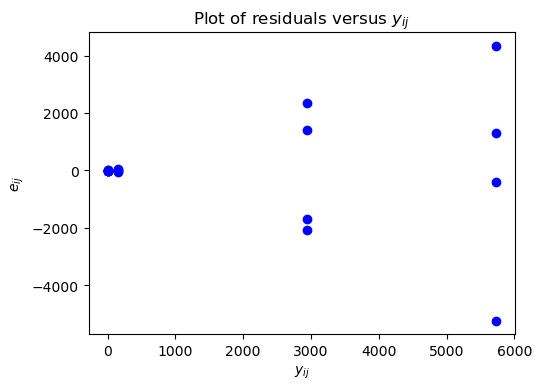

In [150]:
res = residual[:,1]
y = []
for i in range(a):
    for j in range(n):
        y.append(np.mean(data[(data[:,0] == i + 1),1]))

plt.figure(figsize=(5.5, 4), dpi=100)
plt.scatter(y, res, c = "blue")

plt.title('Plot of residuals versus $y_{ij}$')
# 残差与拟合值

plt.xlabel('$y_{ij}$')
plt.ylabel('$e_{ij}$')

观察上图可知，残差-拟合值关系图呈现向外开口的漏斗形

In [151]:
# 法2：用Bartlett检验进行方差齐性检验
Bartlett, pValue2 = stats.bartlett(data_group1, data_group2, 
                             data_group3, data_group4, data_group5)

bart_stat = stats.chi2.isf(alpha, a-1)

print('Bartlett\'s test P-value:', round(pValue2, 15))

if pValue2 < alpha:
    print('Since p-value < 0.05, reject H0.')
else:
    print('Accept H0')  

Bartlett's test P-value: 4e-15
Since p-value < 0.05, reject H0.


In [152]:
# 法3：用Levene检验进行方差齐性检验
lene, pValue3 = stats.levene(data_group1, data_group2, 
                           data_group3, data_group4, data_group5)
print('\nLevene\'s test P-value:', round(pValue3, 8))
if pValue3 < alpha:
    print('Since p-value < 0.05, reject H0.\n')
else:
    print('Accept H0\n')  


Levene's test P-value: 0.00434385
Since p-value < 0.05, reject H0.



由上述分析可知:  
1. 残差与拟合值的关系图：呈现开口向外的漏斗型；
2. Bartlett's test P-value: 4e-15 < 0.05；
3. Levene's test P-value: 0.00434385 < 0.05.  

**结论：**由上述三种检验方法可拒绝原假设，认为方差具有异方差性。

#### Q3:若实验中的数据满足方差齐性，试判断失效时间如何进行方差稳定化变换。

$\color{blue}{{Q3 \; Solution}}$ 

In [153]:
# 求出各估计方法的标准差sigma_i和均值mu_i的对数
# 通常用样本的标准差std_i和均值y_i代替总体的标准差sigma_i和均值mu_i

log_y_1 = math.log(np.mean(data_group1))
log_y_2 = math.log(np.mean(data_group2))
log_y_3 = math.log(np.mean(data_group3))
log_y_4 = math.log(np.mean(data_group4))
log_y_5 = math.log(np.mean(data_group5))

log_y = [log_y_1, log_y_2, log_y_3, log_y_4, log_y_5]

log_std_1 = math.log(np.std(data_group1, ddof = 1))
log_std_2 = math.log(np.std(data_group2, ddof = 1))
log_std_3 = math.log(np.std(data_group3, ddof = 1))
log_std_4 = math.log(np.std(data_group4, ddof = 1))
log_std_5 = math.log(np.std(data_group5, ddof = 1))

log_std = [log_std_1, log_std_2, log_std_3, log_std_4, log_std_5]

画出关系图以对方差稳定化变换做进一步研究，由于组间方差和均值在数量级上有差异，所以对横坐标取对数便于作图

slope: 0.9211


Text(0, 0.5, '$log_{Si}$')

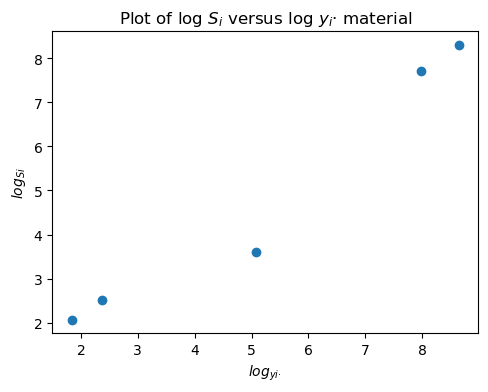

In [154]:
# linregress(x,y)为线性回归函数，如果用sklearn的话也可以直接调包

slope, intercept, r_value, p_value, std_err = stats.linregress(log_y, log_std)
print('slope:', round(slope, 4))

# 作图
plt.figure(figsize=(5.5, 4), dpi=100)
plt.scatter(log_y, log_std)
plt.title('Plot of log $S_{i}$ versus log $y_{i}$· material')
plt.xlabel('$log_{yi·}$')
plt.ylabel('$log_{Si}$')

In [155]:
# 对y值做幂变换，即通过开根号进行方差稳定化变换
# math.pow
trans_group1 = data_group1 ** 0.08
trans_group2 = data_group2 ** 0.08
trans_group3 = data_group3 ** 0.08
trans_group4 = data_group4 ** 0.08
trans_group5 = data_group5 ** 0.08

trans_groups = [trans_group1, trans_group2, trans_group3, trans_group4, trans_group5]
trans_groups1 = pd.DataFrame(trans_groups)
print(trans_groups1)

          0         1         2         3
0  1.456503  1.498553  1.524137  1.513678
1  1.000000  1.057018  1.117287  1.260149
2  1.720119  1.769780  1.985109  1.954875
3  1.642738  2.031448  1.986040  2.090130
4  1.168444  1.137411  1.309157  1.057018


In [156]:
# 计算变换后残差
df = np.array(trans_groups)
trans_data = [data[:,0], df.reshape(1, 20).tolist()[0]] #检查数据维度和样本量
trans_data = np.array(trans_data * 1).T
trans_data_res = trans_data * 1
for k in range(a):
    trans_cnt = trans_data_res[trans_data_res[:,0] == k + 1,1]
    trans_data_res[trans_data_res[:,0] == k + 1,1] = trans_cnt - np.mean(trans_cnt)

Text(0, 0.5, 'e_ij*')

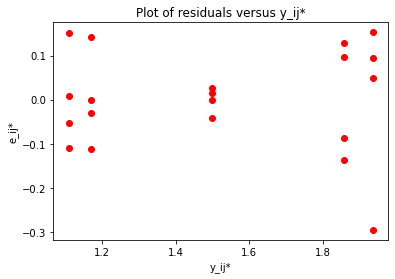

In [157]:
# 变换后的残差与拟合值的关系图
trans_res = trans_data_res[:,1]
trans_y = []
for i in range(a):
    for j in range(n):
        trans_y.append(np.mean(trans_data[(trans_data[:,0] == i + 1),1]))
plt.scatter(trans_y, trans_res, c = "red")
plt.title('Plot of residuals versus y_ij*')
plt.xlabel('y_ij*')
plt.ylabel('e_ij*')

Box-Cox变换的一般形式为：  
$$ y(\lambda)=\left\{
\begin{aligned}
\frac{(y+c)^{\lambda}-1}{\lambda} & ,&\lambda \neq 0 \\
\ln (y+c) & ,& \lambda = 0 
\end{aligned}
\right.
$$
式中$y(\lambda)$为经Box-Cox变换后得到的新变量，$y$ 为原始连续因变量，其中 $y+c$ 的 $+c$ 是为了确保 $(y+c)>0$,因为在Box-Cox变换中要求 $y>0$，$\lambda$ 为变换参数。  

可见，斜率约为0.92，可取$\lambda=1-\alpha=0.08$，并对数据做方差稳定化变换

随后我们检验变换后的数据是否依然存在方差异性

lmax_mle:  0.016756747738272192
lmax_pearsonr:  0.014405180057034986


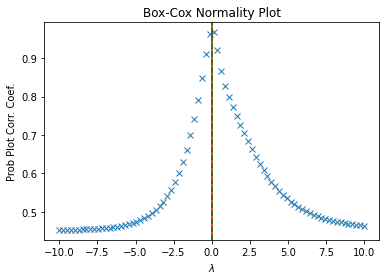

Text(0, 0.5, 'e_ij*')

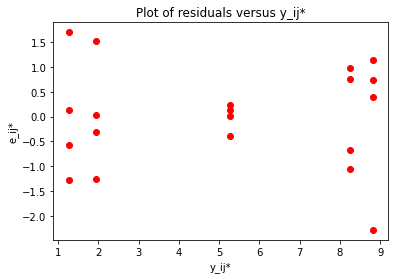

In [158]:
# 作Box-Cox变换
bc, lmax_mle = stats.boxcox(data[:,1])
lmax_pearsonr = stats.boxcox_normmax(data[:,1])
print('lmax_mle: ', lmax_mle)
print('lmax_pearsonr: ', lmax_pearsonr)

fig = plt.figure()
ax = fig.add_subplot(111)
prob = stats.boxcox_normplot(data[:,1], -10, 10, plot = ax)

#似然函数！对应y轴，我们要对应似然最大
ax.axvline(lmax_mle, color='r')
ax.axvline(lmax_pearsonr, color='g', ls='--')
plt.show()

# 计算变换后残差
bc_group1 = bc[0:4]
bc_group2 = bc[4:8]
bc_group3 = bc[8:12]
bc_group4 = bc[12:16]
bc_group5 = bc[16:20]
bc_groups = [bc_group1, bc_group2, bc_group3, bc_group4, bc_group5]
bc_groups1 = pd.DataFrame(bc_groups)
# print(bc_groups1)
df = np.array(bc_groups)
bc_data = [data[:,0], df.reshape(1, 20).tolist()[0]]
bc_data = np.array(bc_data * 1).T
bc_data_res = bc_data * 1
for k in range(a):
    bc_cnt = bc_data_res[bc_data_res[:,0] == k + 1,1]
    bc_data_res[bc_data_res[:,0] == k + 1,1] = bc_cnt - np.mean(bc_cnt)

# 变换后的残差与拟合值的关系图
bc_res = bc_data_res[:,1]
bc_y = []
for i in range(a):
    for j in range(n):
        bc_y.append(np.mean(bc_data[(bc_data[:,0] == i + 1),1]))
plt.scatter(bc_y, bc_res, c = "red")
plt.title('Plot of residuals versus y_ij*')
plt.xlabel('y_ij*')
plt.ylabel('e_ij*')



观察上图可发现：残差-拟合值关系不再呈现漏斗形，我们暂时认为其不再具有方差异性，在Q4中给出定量的检验

#### Q4:基于变换后的数据，试判断 5 种绝缘材料的性能是否存在差异

$\color{blue}{{Q4 \; Solution}}$ 

In [159]:
# 变换后，再用Levene检验进行方差齐性检验
transformed_lene, pVal4 = stats.levene(transformed_group1, transformed_group2, transformed_group3, transformed_group4, transformed_group5)
print('Levene Test:')
if pVal4 < alpha:
    print('Since p-value < 0.05, reject H0.\n')
else:
    print('pValue=',pVal4,'Accept H0\n')  

Levene Test:
pValue= 0.501324709478838 Accept H0



In [160]:
# Box-Cox变换后，再用Levene检验进行方差齐性检验 
bc_lene, pVal5 = stats.levene(bc_group1, bc_group2, bc_group3, bc_group4, bc_group5)

bc_groups = [bc_group1, bc_group2, bc_group3, bc_group4, bc_group5]
for i in range(4):
    data[0 + 4 * i:4 * (i + 1), 1] = list(bc_groups[i])
df = pd.DataFrame(data, columns = ['method', 'Y'])   

model = sm.ols('Y ~ C(method)', df).fit()
anovaResults = anova_lm(model)
print(anovaResults)

print('Levene Test after Box-Cox:')
if pVal5 < alpha:
    print('Since p-value < 0.05, reject H0.\n')
else:
    print('pValue=',pVal5,'Accept H0\n') 

             df  sum_sq    mean_sq         F    PR(>F)
C(method)   4.0  235.20  58.800000  1.877594  0.166789
Residual   15.0  469.75  31.316667       NaN       NaN
Levene Test after Box-Cox:
pValue= 0.6072523787997315 Accept H0



In [161]:
# 变换后，进行单因子方差分析
tranformed_F0, pVal6 = stats.f_oneway(transformed_group1, transformed_group2, transformed_group3, transformed_group4, transformed_group5)
transformed_groups = [transformed_group1,transformed_group2, transformed_group3, transformed_group4,transformed_group5]
for i in range(4):
    data[0 + 4 * i:4 * (i + 1), 1] = list(transformed_groups[i])
df = pd.DataFrame(data, columns = ['method', 'Y'])   
print('A more elegant way:')
model = sm.ols('Y ~ C(method)', df).fit()
anovaResults = anova_lm(model)
print(anovaResults)

print('One-way ANOVA:')
if pVal6 < alpha:
    print('Since p-value < 0.05, reject H0.\n')
else:
    print('pValue=',pVal6,'Accept H0\n') 

A more elegant way:
             df  sum_sq    mean_sq         F    PR(>F)
C(method)   4.0  297.20  74.300000  2.434735  0.092726
Residual   15.0  457.75  30.516667       NaN       NaN
One-way ANOVA:
Since p-value < 0.05, reject H0.



In [162]:
# Box-Cox变换后
bc_F0, pVal7 = stats.f_oneway(bc_group1, bc_group2, bc_group3, bc_group4, bc_group5)

bc_groups = [bc_group1, bc_group2, bc_group3, bc_group4, bc_group5]
for i in range(4):
    data[0 + 4 * i:4 * (i + 1), 1] = list(bc_groups[i])
df = pd.DataFrame(data, columns = ['method', 'Y'])   

model = sm.ols('Y ~ C(method)', df).fit()
anovaResults = anova_lm(model)
print(anovaResults)

print('One-way ANOVA after Box-Cox:')
if pVal7 < alpha:
    print('Since p-value < 0.05, reject H0.\n')
else:
    print('Accept H0\n')

             df  sum_sq    mean_sq         F    PR(>F)
C(method)   4.0  235.20  58.800000  1.877594  0.166789
Residual   15.0  469.75  31.316667       NaN       NaN
One-way ANOVA after Box-Cox:
Since p-value < 0.05, reject H0.



In [163]:
transformed_groups = [transformed_group1,transformed_group2, transformed_group3, transformed_group4,transformed_group5]
for i in range(4):
    data[0 + 4 * i:4 * (i + 1), 1] = list(transformed_groups[i])
df = pd.DataFrame(data, columns = ['method', 'Y'])   
print('A more elegant way:')
model = sm.ols('Y ~ C(method)', df).fit()
anovaResults = anova_lm(model)
print(anovaResults)

A more elegant way:
             df  sum_sq    mean_sq         F    PR(>F)
C(method)   4.0  297.20  74.300000  2.434735  0.092726
Residual   15.0  457.75  30.516667       NaN       NaN


对三种变换进行检验得到的结果大体上是相同的。由第一个结论可知，稳定化变换后的残差具有方差齐性(不再具有方差异性)。再进行单因素方差分析，由方差分析表知，P 值均小于 0.05故拒绝原假设， 即认为5种绝缘材料的性能存在差异。

观察可以发现，不同的变换方法对ANOVA Table中各统计量的大小有影响，所以应该对不同变换方法产生的数据都进行检验。

总结：本次实验主要探究残差不满足齐性（具有方差异性）时该如何进行方差分析。经过本次实验，对方差齐性和方差异性的概念有了更深入的理解，同时对单因子方差分析有了更好的掌握。对一些常用统计方法进行了探索，并且观察其运用于变换前和变换后的数据时的差异性。除此之外，对课堂上讲解的Box-Cox变换有了更深入的理解。

**End of Homework2**

助教老师幸苦了～